In [1]:
import pandas as pd
import numpy as np
import os.path as op
import functools
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}   

In [2]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Model development

In [3]:
from torch.nn import Module
from torch import nn

class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=64, kernel_size=(5, 3), stride = (3,1), padding= (16,1), dilation = (2,1)) 
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size = (2,1))
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=(5, 3), stride = 1, padding= (2,1))
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size = (2,1))
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=(5, 3), stride = 1, padding= (2,1))
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(kernel_size = (2,1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(46080, 2)
        self.out = nn.Softmax(dim = 1)

    def forward(self, x):
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.norm3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        y = y.view(y.size()[0],-1)
        y = self.dropout(y)
        y = self.fc1(y)
        y = self.out(y)
        return y

net = CNN()
print(net)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(16, 1), dilation=(2, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Lin

In [4]:
from torchsummary import summary

summary(net, input_size=(1,64,60), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 60]           1,024
       BatchNorm2d-2           [-1, 64, 30, 60]             128
         LeakyReLU-3           [-1, 64, 30, 60]               0
         MaxPool2d-4           [-1, 64, 15, 60]               0
            Conv2d-5          [-1, 128, 15, 60]         123,008
       BatchNorm2d-6          [-1, 128, 15, 60]             256
         LeakyReLU-7          [-1, 128, 15, 60]               0
         MaxPool2d-8           [-1, 128, 7, 60]               0
            Conv2d-9           [-1, 256, 7, 60]         491,776
      BatchNorm2d-10           [-1, 256, 7, 60]             512
        LeakyReLU-11           [-1, 256, 7, 60]               0
        MaxPool2d-12           [-1, 256, 3, 60]               0
          Dropout-13                [-1, 46080]               0
           Linear-14                   

### Apply xavier initializer

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [6]:
net.apply(initialize_weights)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(16, 1), dilation=(2, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Lin

### Adopt CrossEntropyLoss, Adam optimizer with learning rate 10-5

In [7]:
optimizer = optim.Adam(net.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)
criterion = criterion.to(device)

### Early Stopping

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        print(self.path)
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [57]:
early_stopping = EarlyStopping(path= './model/cnn_checkpoint.pt',verbose=True)

./model/cnn_checkpoint.pt


## Load data and split into train and validation data

In [10]:
data =[]
y_train = pd.DataFrame()
for year in range(1993,2000):
    train = np.memmap(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    data.append(train/255)
    label_df_train = pd.read_feather(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))['Ret_20d']
    y_train= pd.concat([y_train,label_df_train],axis= 0)
data = np.concatenate(data, axis=0, out=None)
data.shape

(694871, 64, 60)

In [11]:
y_train.columns = ['Ret_20d']

In [12]:
y_train.shape

(694871, 1)

In [13]:
def labeling(x):
    if x>0:
        return 0
    else:
        return 1

y = y_train['Ret_20d'].apply(labeling)
y = np.array(y).reshape((-1,1))

In [14]:
from sklearn.model_selection import train_test_split
import gc
x_train, x_val, y_train, y_val = train_test_split(data, y, test_size=0.3, random_state=10, shuffle=True)
del data,y
gc.collect()

0

In [15]:
y_train.shape

(486409, 1)

In [16]:
import torch.utils.data as Data
from torch.utils.data import TensorDataset

BATCH_SIZE = 128
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

train_loader = Data.DataLoader(dataset=TensorDataset(x_train, y_train), \
                               batch_size=BATCH_SIZE, shuffle=True)
valid_loader = Data.DataLoader(dataset=TensorDataset(x_val, y_val), \
                               batch_size=BATCH_SIZE, shuffle=True)

In [17]:
del x_train,y_train,x_val,y_val
gc.collect()

45

In [18]:
len(train_loader)

3801

In [58]:
num_epochs = 2000
loss_count = []

validation_loss = []
validation_acc = []
for epoch in range(num_epochs):
    for step,(b_x,b_y) in enumerate(train_loader):
        net.train()
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        b_y = b_y.reshape(b_y.size()[0],)
        b_x = torch.unsqueeze(b_x,dim=1).float()
        output = net(b_x)
        loss = criterion(output, b_y.reshape(BATCH_SIZE,).long())
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()                

        if step%20 == 0:
            temp = loss.cpu()
            loss_count.append(temp.detach().numpy())
            print('epoch: {}: '.format(epoch+1),'iteration: {}:\t'.format(step+1),'loss:', loss.item())
            torch.save(net.state_dict(),r'./model/cnn_checkpoint.pt')

        if ((step % 200 == 0) & (step != 0)):
            loss_val = 0
            total_val = 0
            correct_val = 0
            net.eval()

            with torch.no_grad():
                for val_step,(v_x,v_y) in enumerate(valid_loader):
                    v_x = v_x.to(device)
                    v_y = v_y.to(device)
                    v_y = v_y.reshape(v_y.size()[0],)
                    v_x = torch.unsqueeze(v_x,dim=1).float()
                    validate_output = net(v_x)
                    validate_loss_new = criterion(validate_output,v_y.long())
                    loss_val += validate_loss_new.item()

                    pred_y = torch.max(validate_output,1)[1].data
                    total_val += v_y.size(0)
                    correct_val += (pred_y == v_y).squeeze().sum()
                loss_val /= len(valid_loader)

            print('Validation times: ', step//200, '| validation loss: %.3f' % loss_val, '| validation accuracy: %.3f' % (correct_val / float(total_val)))
            print('--------------------------------------------------')
            validation_loss.append(loss_val)
            validation_acc.append(correct_val / float(total_val))
            early_stopping(loss_val, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stopping.early_stop:
        break

epoch: 1:  iteration: 1:	 loss: 0.7274898290634155
epoch: 1:  iteration: 21:	 loss: 0.7861272692680359
epoch: 1:  iteration: 41:	 loss: 0.7706305384635925
epoch: 1:  iteration: 61:	 loss: 0.7629300951957703
epoch: 1:  iteration: 81:	 loss: 0.7074761986732483
epoch: 1:  iteration: 101:	 loss: 0.7326621413230896
epoch: 1:  iteration: 121:	 loss: 0.8022302985191345
epoch: 1:  iteration: 141:	 loss: 0.7791987061500549
epoch: 1:  iteration: 161:	 loss: 0.6999830603599548
epoch: 1:  iteration: 181:	 loss: 0.8335579633712769
epoch: 1:  iteration: 201:	 loss: 0.7257198691368103
Validation times:  1 | validation loss: 0.721 | validation accuracy: 0.507
--------------------------------------------------
Validation loss decreased (inf --> 0.720850).  Saving model ...
epoch: 1:  iteration: 221:	 loss: 0.7787879109382629
epoch: 1:  iteration: 241:	 loss: 0.7453786134719849
epoch: 1:  iteration: 261:	 loss: 0.7323696613311768
epoch: 1:  iteration: 281:	 loss: 0.7293095588684082
epoch: 1:  iteration:

KeyboardInterrupt: 

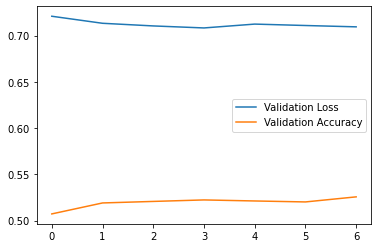

In [60]:
plt.plot(validation_loss,label = "Validation Loss")
plt.plot(validation_acc,label = "Validation Accuracy")
plt.legend()

In [61]:
del train_loader, valid_loader
gc.collect()

61

In [ ]:
test =[]
y_test = pd.DataFrame()
for year in range(2000,2020):
    train = np.memmap(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    test.append(test)
    label_df_train = pd.read_feather(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))['Ret_20d']
    y_test= pd.concat([y_test,label_df_train],axis= 0)
test = np.concatenate(test, axis=0, out=None)
test.shape

In [ ]:
y_test.columns = ['Ret_20d']
y_test = y_test['Ret_20d'].apply(labeling)
y_test = np.array(y_test).reshape((-1,1))

x_test = torch.Tensor(test)
y_test = torch.Tensor(y)

test_loader = Data.DataLoader(dataset=TensorDataset(x_test, y_test), \
                               batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
del test
gc.collect()

In [ ]:
model.load_state_dict(torch.load('./model/cnn_checkpoint.pt'))
global_loss_test = []
global_acc_test = []
prediction = []
y_res = []
for b_x,b_y in test_loader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    b_y = b_y.reshape(b_y.size()[0],)
    b_x = torch.unsqueeze(b_x,dim=1).float()
    output = net(b_x)
    loss = criterion(output, b_y.reshape(b_y.size()[0],).long())

    pred_y = torch.max(output,1)[1].data
    total_val += v_y.size(0)
    correct_val += (pred_y == v_y).squeeze().sum()

    global_loss_test.append(loss.item())
    acc_test = torch.max(prediction_test,1)[1].cpu().numpy() == test_y.cpu().numpy()
    global_acc_test.append(acc_test.mean())
    prediction.extend(torch.max(prediction_test,1)[1].cpu().numpy().tolist())
    y_res.extend(np.array(b).tolist())
    print('|loss_test|', loss_test.cpu().item(), '|test_acc|', acc_test.mean())